In [1]:
import numpy as np
import math
import pennylane as qml
import scipy
import meshio
import os
import itertools
import matplotlib.pyplot as plt
from scipy.linalg import qr
from pennylane import numpy as qnp

import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import gpytorch
from gpytorch.means import ConstantMean, ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.models import ExactGP

from sklearn.gaussian_process import GaussianProcessClassifier,GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,ConstantKernel
from sklearn.model_selection import train_test_split


from tqdm import tqdm
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib import font_manager
from pathlib import Path

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "times"
})
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

In [4]:
mesh = meshio.read('./data_cylinder/snaps/cylinder_1000.vtu')
points=mesh.points[:,:2]
nodes=len(points)
cells_dict=mesh.cells_dict
path='./data_cylinder/snaps/cylinder_'

In [5]:
u_data=[]
v_data=[]
for ids in range(1001):
    mesh = meshio.read(path+str(ids)+'.vtu')
    Velocity = mesh.point_data["Velocity"]
    u_data.append(Velocity[:,0])
    v_data.append(Velocity[:,1])
u_data=np.array(u_data).T
v_data=np.array(v_data).T
VEL=(u_data**2+v_data**2)**0.5

In [7]:
S = VEL[:,1::]
S = S/np.max(np.max(S))
Sd = S[:,0:512]
Spred = S[:,512::]

In [10]:
from funs import centralize, eig, proj_op, reduce
Sd_for_pod=Sd[:,0::4]
Sc_for_pod,s_mean=centralize(Sd_for_pod)
evals_cla, evecs_cla = eig(Sc_for_pod)

In [11]:
# Obtain POD bases using quantum SVD
from quantum_svd import QSVD
M = Sc_for_pod.T@Sc_for_pod
qsvd = QSVD(M)

Loss 1246.470936556602: 100%|██████████████████████████████████████████████████████| 200/200 [3:40:52<00:00, 66.26s/it]


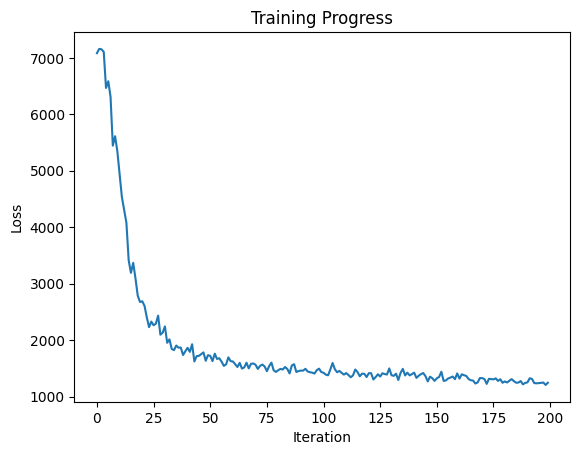

In [166]:
qsvd.initialize_params(n_layers=100)
loss_hist = qsvd.optimize(iterations=200, lr=0.1)
plt.plot(loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Progress")
plt.show()

In [168]:
np.save('./q_evecs.npy',qsvd.evecs)
np.save('./q_evals.npy',qsvd.evals)

In [12]:
q_evecs=np.load("./data_cylinder/q_evecs.npy")
q_evals=np.load("./data_cylinder/q_evals.npy")

In [13]:
sorted_indices = np.argsort(q_evals)
q_evals = q_evals[sorted_indices[::-1]].real
q_evecs = q_evecs[:,sorted_indices[::-1]].real

In [18]:
# quantum framework using 5 POD bases
r=5
Pr_q,s_mean,fid = proj_op(Sd_for_pod,q_evals,q_evecs,r)
Sr_q, u_hat_q = reduce(Sd, Pr_q, s_mean)
Spred_r, u_hat_pred = reduce(Spred, Pr_q, s_mean)
u_hat_q_train=u_hat_q#.reshape(1,-1)
u_mean=np.average(u_hat_q_train,axis=1).reshape(-1,1)
u_hat_q_train_cen=u_hat_q_train-u_mean

In [19]:
# quantum DKL
from quantum_dkl import qdkl
qdkl_q=qdkl(u_hat_q_train_cen)

In [304]:
qdkl_q.train(n_epochs=300)

Epoch 100 | Loss: 0.0784: 100%|██████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]
Epoch 100 | Loss: 0.0158: 100%|██████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]
Epoch 100 | Loss: -0.0905: 100%|█████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]
Epoch 100 | Loss: -0.0510: 100%|█████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]
Epoch 100 | Loss: -0.0962: 100%|█████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.72it/s]
Epoch 100 | Loss: -0.0883: 100%|█████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]
Epoch 100 | Loss: 0.0642: 100%|██████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]
Epoch 100 | Loss: -0.0188: 100%|█████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]
Epoch 100 | Loss: -0.0353: 100%|████████

In [305]:
qdkl_q.pred(999)

100%|████████████████████████████████████████████████████████████████████████████████| 488/488 [36:33<00:00,  4.50s/it]


In [ ]:
u_hat_p_q=qdkl_q.u_hat_p.numpy()+u_mean
Scp = Pr_q@u_hat_p_q
Sp_q=Scp+s_mean
np.save('./pred_quantum_rank5',Sp_q) # save the solution predicted by quantum framework using 5 bases

In [20]:
# classical framework using 5 POD bases
r=5
Pr_cla,s_mean,fid = proj_op(Sd_for_pod,evals_cla,evecs_cla,r)
Sr_cla, u_hat_cla = reduce(Sd, Pr_cla, s_mean)
Spred_r, u_hat_pred = reduce(Spred, Pr_cla, s_mean)
u_hat_cla_train=u_hat_cla
u_mean=np.average(u_hat_cla_train,axis=1).reshape(-1,1)
u_hat_cla_train_cen=u_hat_cla_train-u_mean

In [22]:
#classical DKL
from classical_dkl import cdkl
cdkl=cdkl(u_hat_q_train_cen)
cdkl.train(n_epochs=3000)

Epoch 1000 | Loss: -0.1213: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.52it/s]
Epoch 1000 | Loss: -0.1458: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.15it/s]
Epoch 1000 | Loss: -0.8448: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.97it/s]
Epoch 1000 | Loss: -0.5601: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.72it/s]
Epoch 1000 | Loss: -0.0420: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.03it/s]


In [26]:
cdkl.pred(initial_level=511,level=800)
u_hat_p_cla=cdkl.u_hat_p
u_hat_p_cla=u_hat_p_cla.numpy()+u_mean
Scp = Pr_q@u_hat_p_cla
Sp_cla=Scp+s_mean

100%|███████████████████████████████████████████████████████████████████████████████████| 289/289 [00:01<00:00, 283.03it/s]


In [27]:
np.save('./pred_classical_rank5',Sp_cla) #save the solution predicted by classical framework using 5 bases

In [45]:
# load the predicted solution
pred_classical_rank5=np.load('./data_cylinder/pred_classical_rank5.npy')
pred_classical_rank2=np.load('./data_cylinder/pred_classical_rank2.npy')
pred_quantum_rank5=np.load('./data_cylinder/pred_quantum_rank5.npy')
pred_quantum_rank2=np.load('./data_cylinder/pred_quantum_rank2.npy')

In [43]:
import matplotlib.ticker as mticker
def visualize(points,vel1, cells_dict,fig_path,label, lb=0, ub=1, n_points=6, color_levels=500):
    
    x = points[:, 0]
    y = points[:, 1]
    if "triangle" in cells_dict:
        triangles = cells_dict["triangle"]
    elif "quad" in cells_dict:
        from scipy.spatial import Delaunay
        tri = Delaunay(points)
        triangles = tri.simplices
    else:
        raise ValueError("Unsupported cell type")
    formatter = mticker.StrMethodFormatter('{x:.2f}')
    fig, ax = plt.subplots(figsize=(10, 10))
    levels = np.linspace(lb, ub, color_levels)
    vel1_clipped = np.clip(vel1, lb+0.0001, ub-0.0001)
    cntr = ax.tricontourf(x, y, triangles,
                          vel1_clipped,
                          cmap=custom_green_cmap,
                          levels=levels,
                          extend='neither')
    cbar = fig.colorbar(cntr, ax=ax, orientation='horizontal', 
                        location='bottom', 
                        pad=0.05, 
                        aspect=100, 
                        extend='neither')
    cbar.set_ticks(np.linspace(lb, ub, n_points))
    ax.set_xlim(-0.2, 1.8)
    ax.set_ylim(-0.2, 0.2)
    ax.set_aspect('equal')
    plt.tight_layout(pad=0.2)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar.ax.tick_params(labelsize=30)

    plt.xlabel(r'\textbf{'+label+'}', fontsize= 30)
    plt.savefig(fig_path, bbox_inches='tight', pad_inches=0.02)
    plt.show()

In [46]:
import matplotlib.colors as mcolors
def create_custom_green_cmap():
    colors = [
        (0.0, 'blue'),
        (0.05, 'blue'),
        (0.2, 'cyan'),
        (0.4, 'chartreuse'),
        (0.5, 'chartreuse'),
        (0.6, 'yellow'),
        (0.9, 'red'),
        (1.0, 'red')
    ]
    return mcolors.LinearSegmentedColormap.from_list('custom_green', colors)

custom_green_cmap = create_custom_green_cmap()